In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ete3

/home/phil/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gg_tree_path = "greengenes/data/gg_13_5_otus_99_annotated.tree"

In [3]:
# First we define some functions to covariance matrices

def _tree_to_covariance(tree: ete3.Tree) -> np.ndarray:
    """Given an ete3 tree, return the covariance matrix of the tree."""
    return np.exp(
        -np.array([[tree.get_distance(i, j) for i in tree] for j in tree])
    )


def _lambda_rescale(C: np.ndarray, lam: float) -> np.ndarray:
    """Multiply off-diagonal elements of matrix by lambda."""
    C_scaled = C.copy() * lam
    np.fill_diagonal(C_scaled, 1)
    return C_scaled


def cov(path: str, lam: float) -> np.ndarray:
    """Load tree, return rescaled covariance matrix."""
    return _lambda_rescale(
        _tree_to_covariance(
            ete3.Tree(path, format=1, quoted_node_names=True), 
            lam
        )
    )


# Manageable tree
tree = ete3.Tree(
    gg_tree_path,
    format=1,
    quoted_node_names=True,
)
tree.prune(tree.get_leaves()[:10])

C = _tree_to_covariance(tree)

In [4]:
from scipy.stats import multivariate_normal

def brownian_loglikelihood(cov_matrix: np.ndarray, values: np.ndarray) -> float:
    """Likelihood( values | cov_matrix )"""
    return multivariate_normal.logpdf(values, cov=cov_matrix)

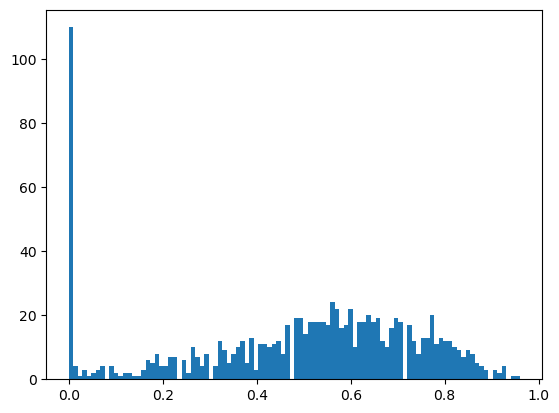

In [5]:
def find_pagelslambda(cov_matrix: np.ndarray, values: np.ndarray) -> float:
    """Find the Pagel's lambda that maximizes the likelihood."""
    best_ll = -np.inf
    best_lam = 0
    for lam in np.linspace(0, 1, 101):
        C_scaled = _lambda_rescale(cov_matrix, lam)
        if brownian_loglikelihood(C_scaled, values) > best_ll:
            best_ll = brownian_loglikelihood(C_scaled, values)
            best_lam = lam
    return best_lam

# Try out lambda estimation on a big subtree
lambdas = []

for i in range(1000):
    values = np.random.multivariate_normal(
        np.zeros(len(tree)), _lambda_rescale(C, 0.5)
    )

    # Find the lambda that maximizes the likelihood
    lambdas.append(find_pagelslambda(C, values))

plt.hist(lambdas, bins=100)
plt.show()

In [6]:
# Load seed plant traits - treat '.' and ',' as decimal separators
seedplant_traits = pd.read_csv("./seedplants/traits.csv", index_col=0, sep=";", decimal=",")
seedplant_traits.head()

,Species name,Occurrence,maxH,Wd,Sm,Shade,N,height,ShadeTol
Code,,,,,,,,,
ABBA,Abies balsamea,7759.0,25.0,0.34,7.6,5.0,1.66,tall,high
ACNE,Acer negundo,0.0,20.0,0.44,34.0,3.5,2.50,tall,high
ACNI,Acer nigrum,1.0,30.0,0.52,65.0,3.0,1.83,tall,high
ACPE,Acer pensylvanicum,665.0,10.0,0.44,41.0,3.5,2.22,medium,high
ACPL,Acer platanoides,0.0,15.0,0.51,172.0,4.2,1.99,medium,high


In [7]:
seedplant_tree = ete3.Tree("./seedplants/tree.nwk", format=0)

print(seedplant_tree)


      /-LITU
     |
     |            /-COAL
     |         /-|
     |        |   \-COST
     |        |
     |        |      /-CABI
     |      /-|   /-|
     |     |  |  |  |   /-FRNI
     |     |  |  |   \-|
     |     |  |  |     |   /-FRAM
     |     |   \-|      \-|
     |     |     |         \-FRPE
     |     |     |
     |     |     |   /-NEMU
     |     |      \-|
     |     |         \-VICA
     |     |
     |     |                        /-CACA
     |     |                     /-|
     |     |                  /-|   \-OSVI
     |     |                 |  |
     |     |                 |   \-COCO
     |     |               /-|
     |     |              |  |      /-ALCR
     |     |              |  |   /-|
     |     |              |  |  |   \-ALRU
     |     |              |   \-|
     |     |              |     |   /-BEPO
     |     |              |      \-|
     |     |            /-|        |   /-BEPA
     |     |           |  |         \-|
     |     |           |  |    

In [8]:
# Check lambda values

seedplant_C = _tree_to_log_covariance(seedplant_tree)

for col in seedplant_traits.columns:
    try:
        values = seedplant_traits[col].values
        lam = find_pagelslambda(seedplant_C, values)
        print(f"{col}: {lam}")
    except Exception as e:
        print(f"{col}: {e}")

NameError: name '_tree_to_log_covariance' is not defined

In [ ]:
seedplant_C

array([[1.        , 0.84356261, 0.84356261, ..., 0.7398491 , 0.7398491 ,
        0.7398491 ],
       [0.84356261, 1.        , 0.98277113, ..., 0.7398491 , 0.7398491 ,
        0.7398491 ],
       [0.84356261, 0.98277113, 1.        , ..., 0.7398491 , 0.7398491 ,
        0.7398491 ],
       ...,
       [0.7398491 , 0.7398491 , 0.7398491 , ..., 1.        , 0.86745616,
        0.86745616],
       [0.7398491 , 0.7398491 , 0.7398491 , ..., 0.86745616, 1.        ,
        0.97554932],
       [0.7398491 , 0.7398491 , 0.7398491 , ..., 0.86745616, 0.97554932,
        1.        ]])

In [ ]:
# Print loglikelihoods for each lambda

for col in seedplant_traits.columns:
    try:
        values = seedplant_traits[col].values
        print(f"{col}: {brownian_loglikelihood(C_scaled, values)}")
    except Exception as e:
        print(f"{col}: {e}")

NameError: name 'seedplant_traits' is not defined